In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader 
import torchvision

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from PIL import Image, ImageDraw
import pandas as pd
import einops
import itertools

from gfn_attractors.misc import utils

In [2]:
device = 1
torch.tensor(0, device=device)

tensor(0, device='cuda:1')

# Data

Specify maximum digit to include in the dataset

In [3]:
img_dims = (14, 14)
dataset = torchvision.datasets.MNIST('/data2/pdp/ajhnam/gfnsl', train=True, download=False, transform=torchvision.transforms.ToTensor())

data = torch.stack([d[0] for d in dataset], 0).view(-1, 14, 2,14, 2).mean((2,4)).view(-1, 14**2)
labels = torch.tensor([d[1] for d in dataset], device=device).long()
data = (data>0.5).float().to(device)

In [4]:
max_digit = 3

subdata = data[labels <= max_digit]
sublabels = labels[labels <= max_digit]
idx = np.random.permutation(len(subdata))
tr_data = subdata[idx[:-500]]
tr_labels = sublabels[idx[:-500]]
te_data = subdata[idx[-500:]]
te_labels = sublabels[idx[-500:]]
len(tr_data)

24254

# Helper functions

In [5]:
def render(*imgs, n_sample=10, size=100, seed=None, astype=None, mode=None):
    """
    Randomly draws n_sample images from each set of images in imgs and renders them
    
    *imgs: list of np.ndarray of shape [n, width, height]
    """
    if n_sample is not None:
        n_sample = min(len(imgs[0]), n_sample)
        idx = np.random.default_rng(seed).permutation(n_sample)
            
    for im in imgs:
        if n_sample is not None:
            im = im[idx]
    
        im = im.detach().view(-1, *img_dims)
        num_im = len(im)
        im = torch.cat(im.split(1, dim=0), dim=-1).squeeze(0).cpu().numpy()
        if astype is not None:
            im = im.astype(astype)
        im = Image.fromarray(im, mode=mode).resize((size*num_im, size))
        im.show()

# Model

In [6]:
class DAE(nn.Module):
    """
    Autoregressively generates a sequence of `length` tokens, which is then used to predict z.
    The decoder doesn't really treat it as a sequence. It just consumes a multi-hot vector.
    Since it's autoregressive, no Pb in loss.
    """
    
    def __init__(self, dim_z, vocab_size, length, dim_h=200):
        """
        vocab_size: number of possible tokens per slot, i.e. 'alphabet size'
        length: number of tokens in discrete latent space
        """
        super().__init__()
        self.dim_z = dim_z
        self.vocab_size = vocab_size
        self.length = length
        self.dim_h = dim_h
        
        self.encoder = nn.Sequential(
            nn.Linear(dim_z + vocab_size*length, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, vocab_size))
        
        self.decoder = nn.Sequential(
            nn.Linear(vocab_size*length, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, 2*dim_z))
        
    def sample(self, z, p_explore=.1):
        logpf = torch.zeros(z.shape[:-1], device=z.device)
        
        s = F.pad(z, (0, self.vocab_size * self.length))
        tokens = []
        for i in range(self.length):
            logits = self.encoder(s).log_softmax(-1)
            policy = logits.exp()
            policy = (1-p_explore)*policy + p_explore / self.vocab_size
            token = policy.multinomial(1)
            logpf += logits.gather(1, token).flatten()
            s = s.scatter_add(1, token + self.dim_z + i*self.vocab_size, torch.ones_like(token, dtype=s.dtype))
            tokens.append(token.squeeze(-1))
        tokens = torch.stack(tokens, dim=-1)
            
        # predict z
        s = s[...,self.dim_z:]
        theta = self.decoder(s)
        mu, log_sigma, = theta.split(self.dim_z, dim=-1)
        dist = Normal(mu, log_sigma.exp())
        z_hat = dist.sample()
        logpf += dist.log_prob(z_hat).sum(-1)
        
        return tokens, z_hat, logpf

In [7]:
class Model(nn.Module):
    
    def __init__(self, dim_img, dim_z, dim_h=256):
        """
        dim_img: length of flattened input image vector
        dim_z: size of latent z
        """
        super().__init__()
        self.dim_img = dim_img
        self.dim_z = dim_z
        self.dim_h = dim_h
        
        self.transition_model = nn.Sequential(
            nn.Linear(dim_img + dim_z, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, 4*dim_z)
        )
        
        self.img_decoder = nn.Sequential(
            nn.Linear(dim_z, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_h),
            nn.ELU(),
            nn.Linear(dim_h, dim_img)
        )
        
    def sample(self, x, num_steps=4):
        states = []
        s = torch.zeros(*x.shape[:-1], self.dim_z, device=x.device)
        
        balance = 0
        
        theta = self.transition_model(torch.cat([x, s], dim=-1))
        mu_f, log_sigma_f, mu_b, log_sigma_b = theta.split(self.dim_z, dim=-1)
        for i in range(num_steps):
            # Forward
            prev_s = s
            dist = Normal(mu_f, log_sigma_f.exp())
            s = dist.sample()
            balance += dist.log_prob(s).sum(-1)
            states.append(s)
            
            # Backward
            theta = self.transition_model(torch.cat([x, s], dim=-1))
            mu_f, log_sigma_f, mu_b, log_sigma_b = theta.split(self.dim_z, dim=-1)
            if i > 0: # starting state is always the same
                balance -= Normal(mu_b, log_sigma_b.exp()).log_prob(prev_s).sum(-1)
        
        states = torch.stack(states, dim=-2)
        return states, balance

In [8]:
Z = nn.Parameter(torch.tensor(0.))
Z_dae = nn.Parameter(torch.tensor(0.))
model = Model(data.shape[-1], dim_z=20, dim_h=400).to(device)
dae = DAE(dim_z=20, vocab_size=4, length=2).to(device)
optimizer = optim.Adam([{'params': model.parameters(), 'lr': .0001},
                        {'params': dae.parameters(), 'lr': .0001},
                        {'params': [Z], 'lr': .01},
                        {'params': [Z_dae], 'lr': .01}])
prior = Normal(torch.tensor(0., device=device), torch.tensor(5., device=device))

In [9]:
def get_logp_s(states, prior=None):
    """
    states: [batch_size, dim_z] or [batch_size, num_steps, dim_z]
    prior: some distribution to regularize s_t, e.g. Normal(0, 1)
    """
    s = states.view(len(states), -1, model.dim_z)
    z = s[:,-1]
    with torch.no_grad():
        tokens, z_hat, logpf = dae.sample(z, p_explore=.1)
    logp_s = -F.mse_loss(z_hat, z, reduction='none').sum(-1)
    if prior is not None:
        logp_s += prior.log_prob(s).sum((-2, -1))
    return logp_s

  0%|          | 0/20001 [00:00<?, ?it/s]

update: 0 | r_image: -136.159 | z_recon: -40.152 | ew_loss: 22079.459 | id_loss: 174.908 | dae_loss: 234.147


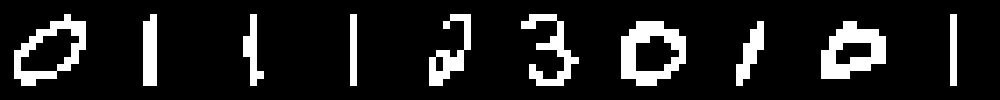

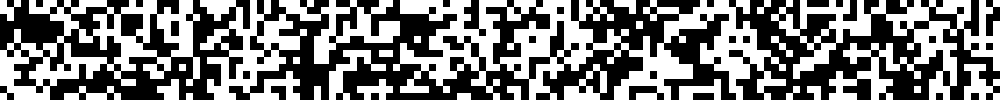

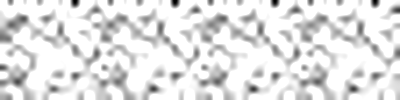

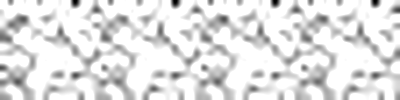

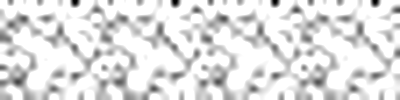

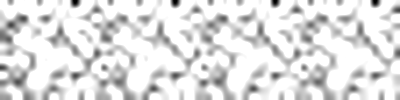

update: 500 | r_image: -51.78 | z_recon: -28.103 | ew_loss: 2831.411 | id_loss: 80.564 | dae_loss: 79.091
update: 1000 | r_image: -48.609 | z_recon: -27.422 | ew_loss: 1983.554 | id_loss: 75.465 | dae_loss: 60.791


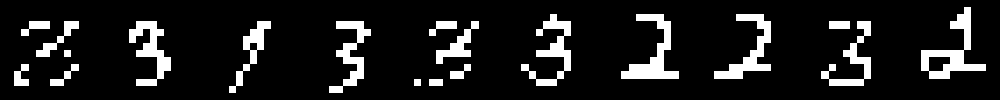

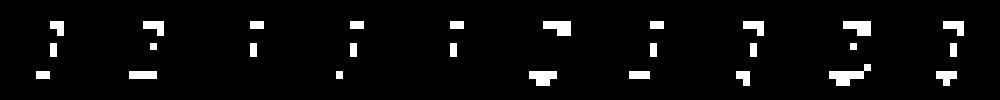

update: 1500 | r_image: -46.241 | z_recon: -23.597 | ew_loss: 1476.712 | id_loss: 71.036 | dae_loss: 44.684
update: 2000 | r_image: -42.756 | z_recon: -22.098 | ew_loss: 1076.239 | id_loss: 64.362 | dae_loss: 40.921


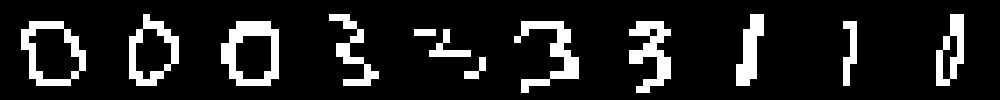

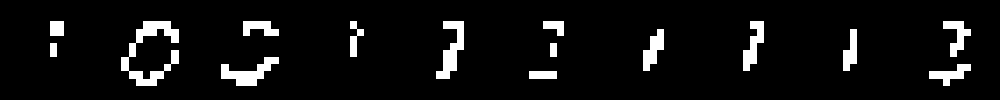

update: 2500 | r_image: -42.26 | z_recon: -21.755 | ew_loss: 751.75 | id_loss: 64.329 | dae_loss: 50.73


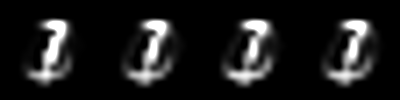

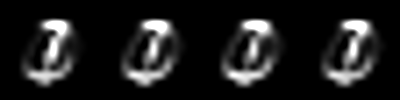

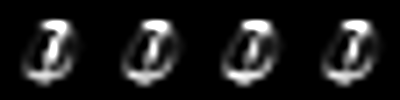

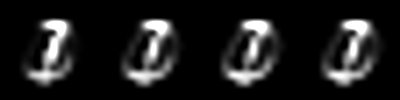

update: 3000 | r_image: -41.253 | z_recon: -20.537 | ew_loss: 577.542 | id_loss: 61.779 | dae_loss: 47.314


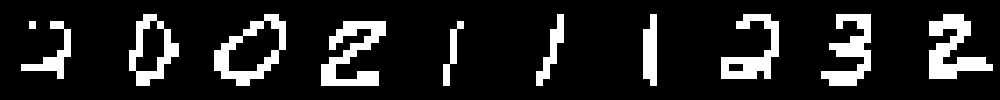

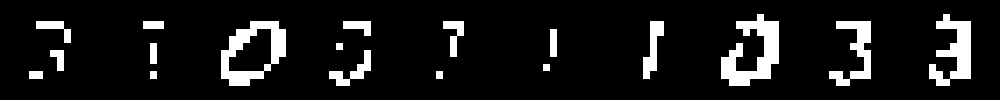

update: 3500 | r_image: -39.18 | z_recon: -21.445 | ew_loss: 401.688 | id_loss: 60.783 | dae_loss: 40.347
update: 4000 | r_image: -41.066 | z_recon: -19.619 | ew_loss: 343.025 | id_loss: 62.641 | dae_loss: 39.906


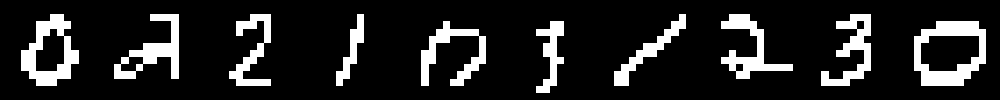

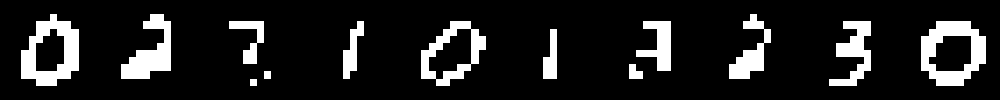

update: 4500 | r_image: -38.369 | z_recon: -21.039 | ew_loss: 241.266 | id_loss: 58.556 | dae_loss: 43.811
update: 5000 | r_image: -37.024 | z_recon: -22.133 | ew_loss: 290.422 | id_loss: 59.431 | dae_loss: 37.264


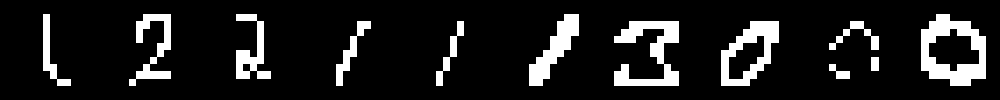

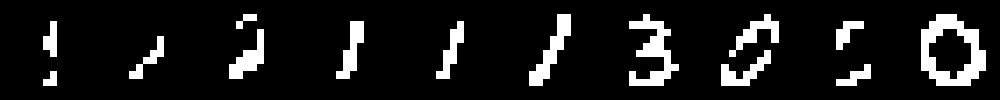

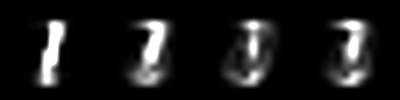

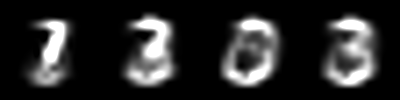

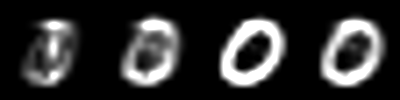

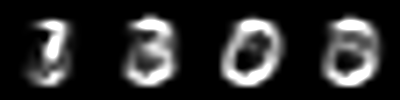

update: 5500 | r_image: -33.446 | z_recon: -22.622 | ew_loss: 125.601 | id_loss: 57.92 | dae_loss: 78.183
update: 6000 | r_image: -32.197 | z_recon: -24.402 | ew_loss: 109.844 | id_loss: 56.347 | dae_loss: 75.011


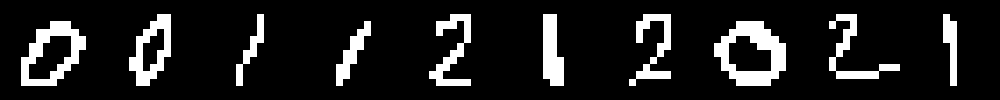

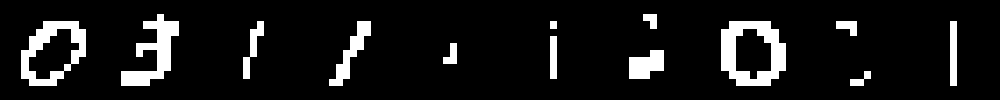

update: 6500 | r_image: -36.251 | z_recon: -23.396 | ew_loss: 120.248 | id_loss: 60.32 | dae_loss: 70.057
update: 7000 | r_image: -32.911 | z_recon: -24.534 | ew_loss: 148.321 | id_loss: 56.967 | dae_loss: 103.184


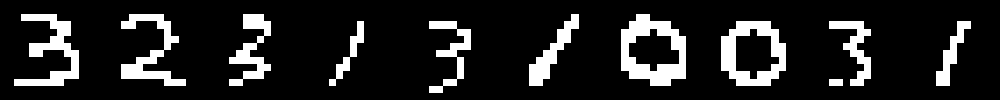

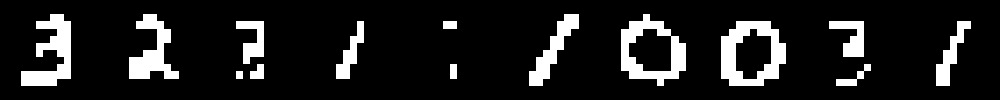

update: 7500 | r_image: -33.724 | z_recon: -23.907 | ew_loss: 85.321 | id_loss: 59.712 | dae_loss: 88.557


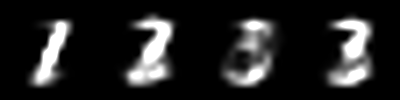

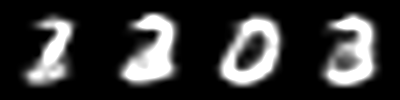

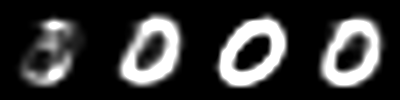

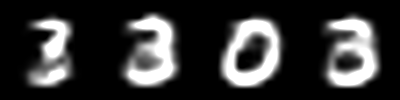

update: 8000 | r_image: -32.375 | z_recon: -25.603 | ew_loss: 96.371 | id_loss: 57.677 | dae_loss: 114.138


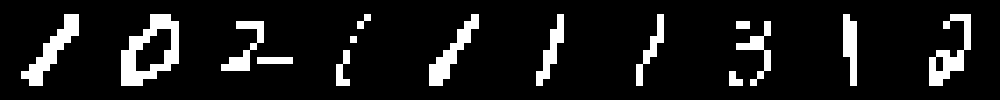

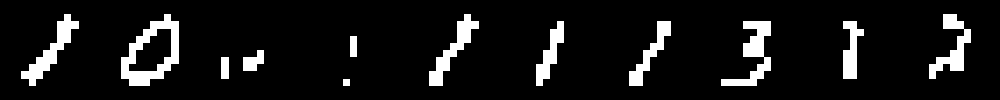

update: 8500 | r_image: -31.036 | z_recon: -27.039 | ew_loss: 66.499 | id_loss: 56.724 | dae_loss: 114.659
update: 9000 | r_image: -31.931 | z_recon: -25.239 | ew_loss: 125.559 | id_loss: 57.858 | dae_loss: 86.639


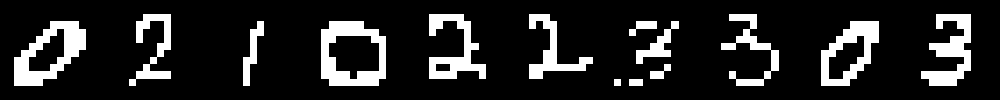

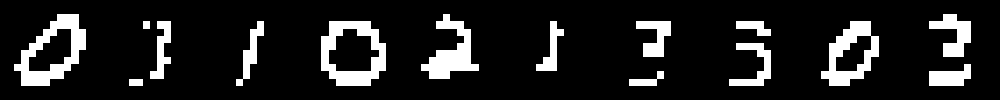

update: 9500 | r_image: -33.451 | z_recon: -30.217 | ew_loss: 127.151 | id_loss: 63.393 | dae_loss: 163.819
update: 10000 | r_image: -34.646 | z_recon: -26.528 | ew_loss: 149.964 | id_loss: 63.212 | dae_loss: 89.75


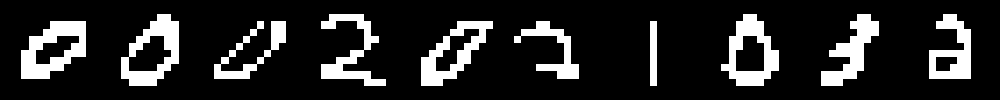

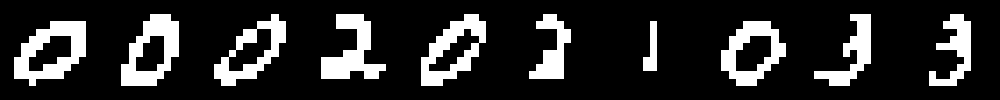

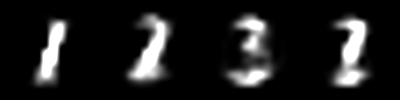

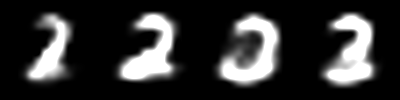

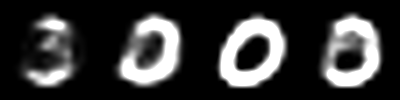

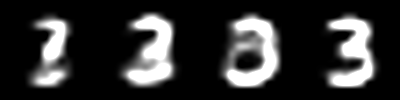

update: 10500 | r_image: -31.923 | z_recon: -28.203 | ew_loss: 145.487 | id_loss: 58.056 | dae_loss: 109.924
update: 11000 | r_image: -32.195 | z_recon: -29.025 | ew_loss: 155.76 | id_loss: 59.971 | dae_loss: 97.052


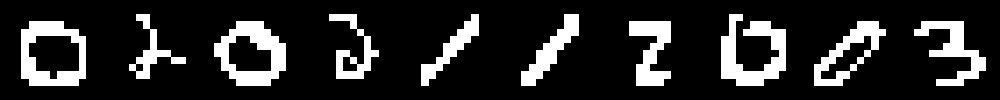

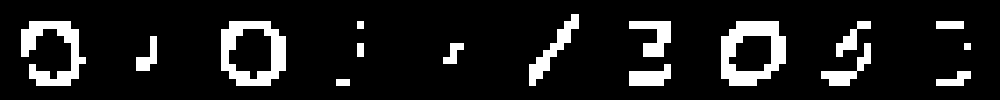

update: 11500 | r_image: -30.713 | z_recon: -28.695 | ew_loss: 185.079 | id_loss: 59.596 | dae_loss: 157.295
update: 12000 | r_image: -32.632 | z_recon: -29.209 | ew_loss: 143.447 | id_loss: 61.039 | dae_loss: 113.034


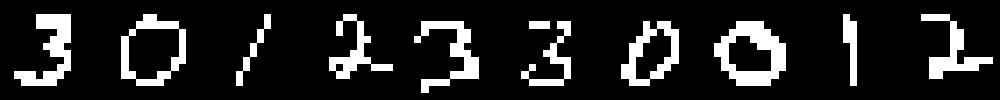

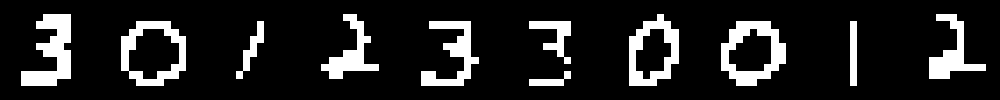

update: 12500 | r_image: -30.041 | z_recon: -25.916 | ew_loss: 136.496 | id_loss: 57.866 | dae_loss: 65.352


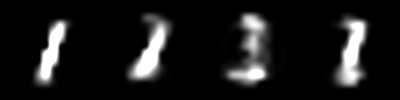

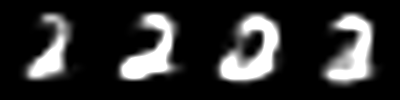

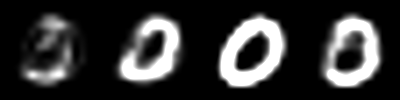

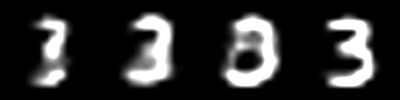

update: 13000 | r_image: -30.444 | z_recon: -29.638 | ew_loss: 180.478 | id_loss: 59.691 | dae_loss: 110.957


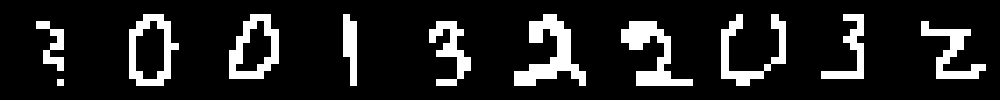

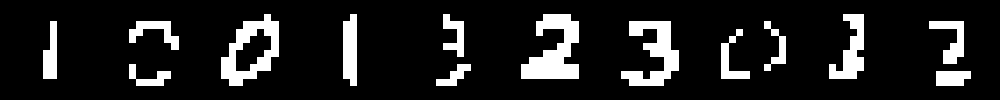

update: 13500 | r_image: -30.732 | z_recon: -29.433 | ew_loss: 164.01 | id_loss: 60.086 | dae_loss: 92.322
update: 14000 | r_image: -31.142 | z_recon: -27.844 | ew_loss: 117.536 | id_loss: 59.32 | dae_loss: 101.883


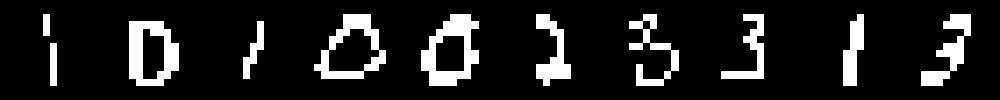

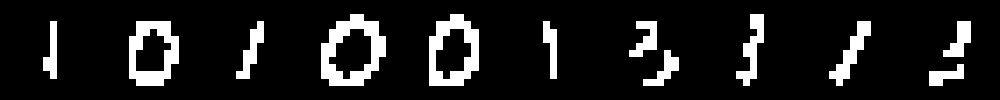

update: 14500 | r_image: -29.51 | z_recon: -25.173 | ew_loss: 296.707 | id_loss: 55.175 | dae_loss: 67.975
update: 15000 | r_image: -29.692 | z_recon: -30.161 | ew_loss: 263.485 | id_loss: 60.525 | dae_loss: 117.9


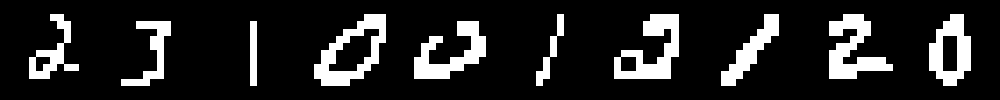

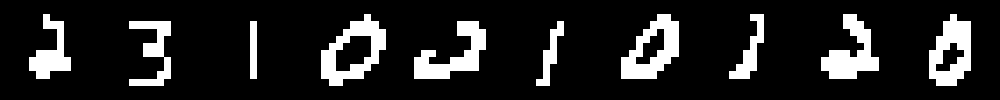

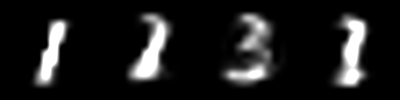

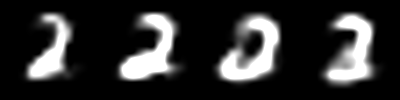

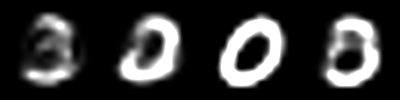

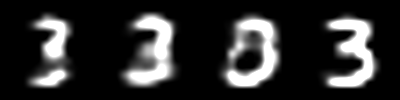

update: 15500 | r_image: -28.42 | z_recon: -31.409 | ew_loss: 143.436 | id_loss: 58.468 | dae_loss: 161.195
update: 16000 | r_image: -30.361 | z_recon: -33.234 | ew_loss: 207.278 | id_loss: 62.279 | dae_loss: 88.93


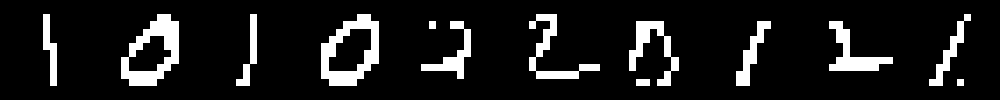

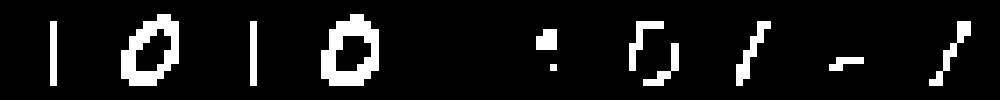

update: 16500 | r_image: -31.255 | z_recon: -30.266 | ew_loss: 169.568 | id_loss: 62.324 | dae_loss: 100.759
update: 17000 | r_image: -27.75 | z_recon: -29.41 | ew_loss: 406.081 | id_loss: 59.083 | dae_loss: 76.686


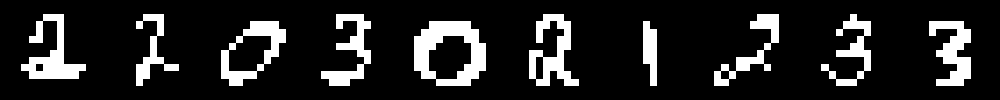

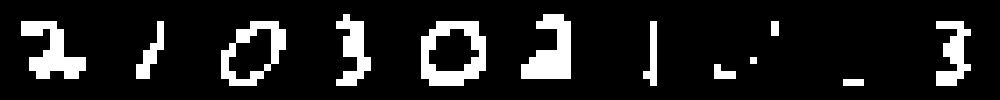

update: 17500 | r_image: -28.727 | z_recon: -28.346 | ew_loss: 406.647 | id_loss: 58.843 | dae_loss: 102.602


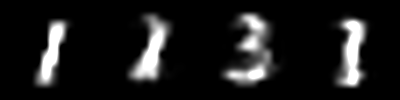

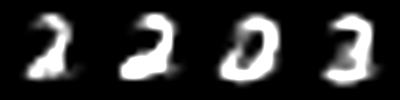

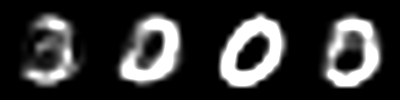

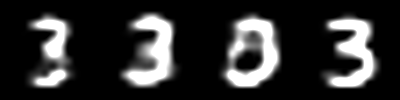

update: 18000 | r_image: -30.764 | z_recon: -30.379 | ew_loss: 94.337 | id_loss: 59.345 | dae_loss: 138.19


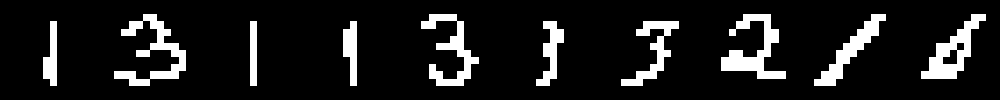

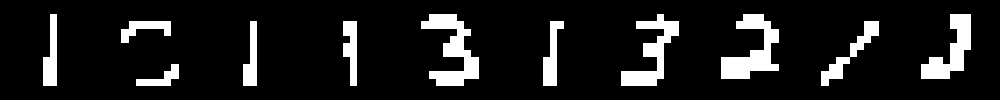

update: 18500 | r_image: -28.252 | z_recon: -28.264 | ew_loss: 268.22 | id_loss: 60.535 | dae_loss: 60.533
update: 19000 | r_image: -29.445 | z_recon: -29.786 | ew_loss: 352.2 | id_loss: 61.933 | dae_loss: 75.713


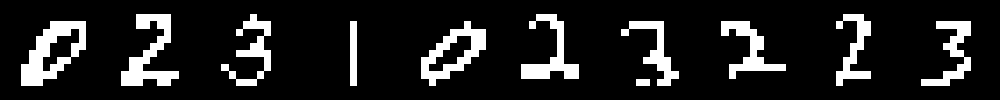

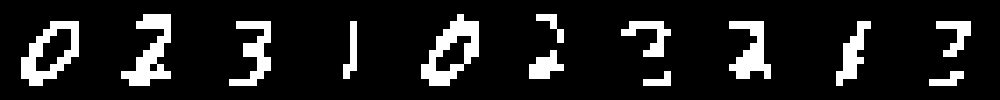

update: 19500 | r_image: -28.55 | z_recon: -29.797 | ew_loss: 1326.899 | id_loss: 58.972 | dae_loss: 87.889
update: 20000 | r_image: -30.052 | z_recon: -31.338 | ew_loss: 163.082 | id_loss: 60.624 | dae_loss: 151.941


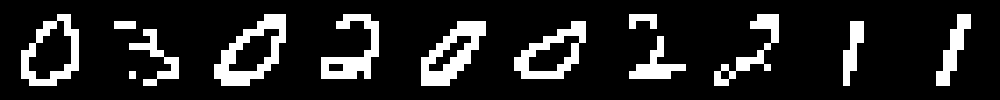

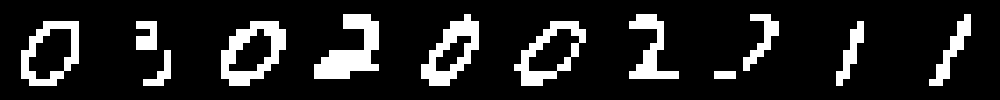

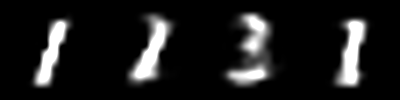

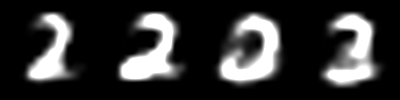

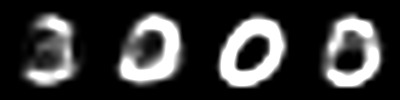

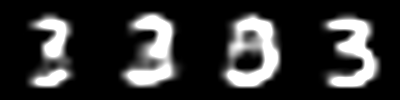

In [10]:
num_updates = 20000
batch_size = 100
num_steps = 4
dataloader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)

for update, x in tqdm(enumerate(utils.cycle(dataloader, 1+num_updates)), total=1+num_updates):
    # E-step
    
    states, balance = model.sample(x, num_steps)
    s_t = states[...,-1,:]
    with torch.no_grad():
        # image reconstruction
        x_hat = model.img_decoder(s_t)
        r_image = -F.binary_cross_entropy_with_logits(x_hat, x, reduction='none').sum(-1)
        logp_s = get_logp_s(states)
        log_reward = logp_s + r_image
    loss = Z + balance - log_reward
    e_loss = (loss**2).mean()
    e_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # M-step: image decoder
    with torch.no_grad():
        states, balance = model.sample(x, num_steps)
        s_t = states[...,-1,:]
        logp_s = get_logp_s(s_t)
    x_hat = model.img_decoder(s_t)
    im_recon = -F.binary_cross_entropy_with_logits(x_hat, x, reduction='none').sum(-1)
    id_loss = -(logp_s + im_recon).mean()
    id_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # M-step: discrete autoencoder
    tokens, z_hat, logpf = dae.sample(s_t, p_explore=.1)
    z_recon = -F.mse_loss(z_hat, s_t, reduction='none').sum(-1)
    loss = Z_dae + logpf - z_recon
    dae_loss = (loss**2).mean()
    dae_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    if update%500 == 0:
        utils.kv_print(update=update, r_image=im_recon.mean(), z_recon=z_recon.mean(), ew_loss=e_loss, id_loss=id_loss, dae_loss=dae_loss)
        
    if update%1000 == 0:
        num_imgs = 10
        idx = np.random.permutation(len(te_data))[:10]
        x = te_data[idx]
        with torch.no_grad():
            states, balance = model.sample(x, num_steps=num_steps)
            x_hat = model.img_decoder(states).sigmoid()
        render(x > .5, x_hat[:,-1] > .5, n_sample=None)
        
    if update%2500 == 0:
        n = 1000
        tokens = torch.tensor(list(itertools.product(range(4), range(4))), device=device)
        num_seqs = len(tokens)
        tokens = einops.repeat(tokens, 'm a -> (m n) a', n=n)
        with torch.no_grad():
            theta = dae.decoder(F.one_hot(tokens).flatten(-2, -1).float())
            mu, log_sigma, = theta.split(dae.dim_z, dim=-1)
            z_hat = Normal(mu, log_sigma.exp()).sample()
            x_hat = model.img_decoder(z_hat).sigmoid() > .5
        im = x_hat.view(num_seqs, n, -1).float().mean(1).view(4, 4, -1)
        render(*(500 * im), n_sample=None)